## Week 10_Wed - LINEAR DATA FITTING WITH UNCERTANTIES

In [28]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [29]:
#Read in the data to a numpy array
data = np.genfromtxt("HW10_2data.dat", names=True, dtype=None)

# print out all columns we just got for free
data.dtype

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

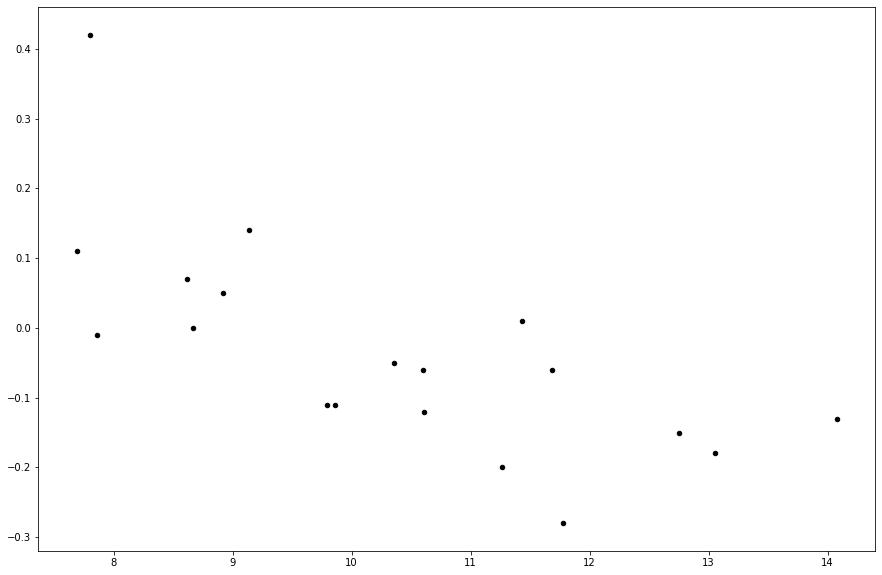

In [30]:
#First let's see what this data looks like
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [31]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.05818663749944188 0.5653511377902967
raw:  [ 0.00020654 -0.00213008] [-0.00213008  0.02264763]


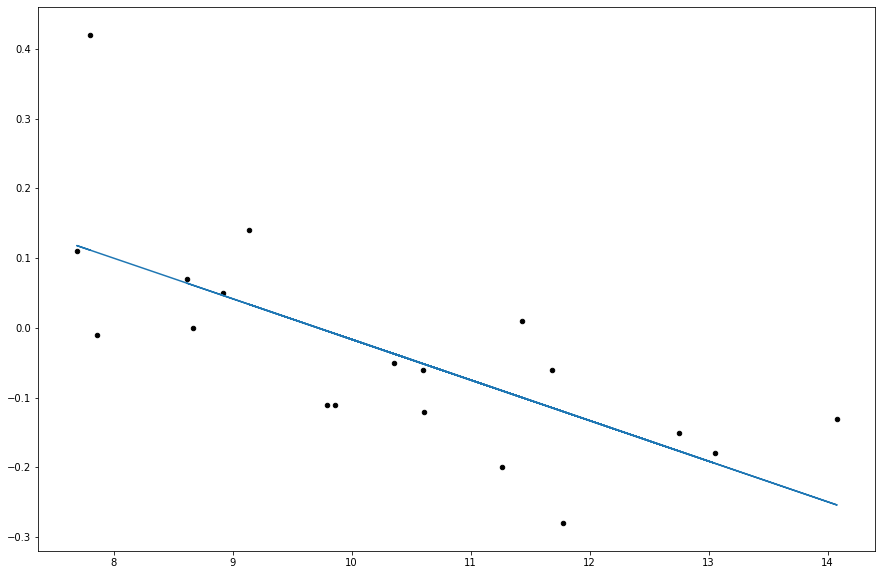

In [32]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


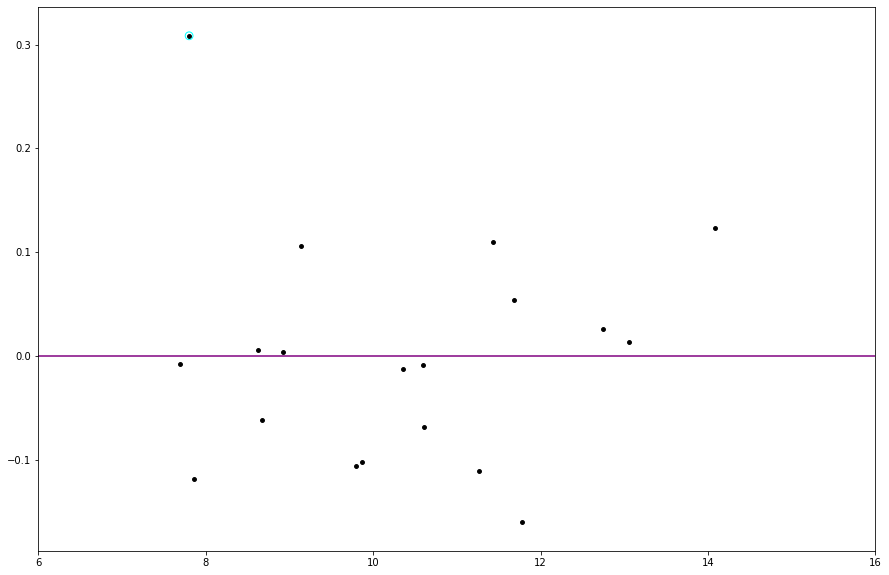

In [33]:
#Let's look into wich data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.2
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.05818663749944188 0.5653511377902967
outliers accounted for:  -0.04338146805673531 0.3967292540601484


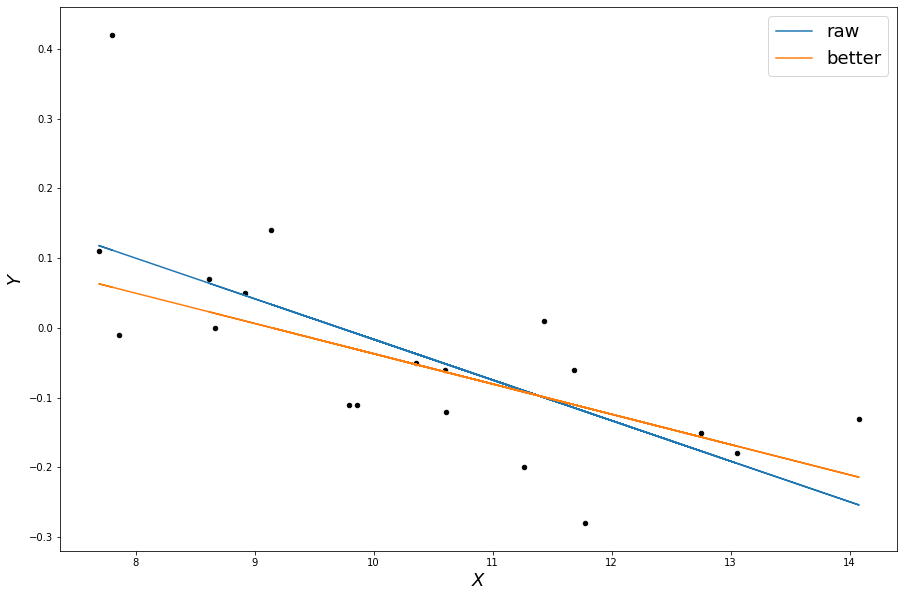

In [34]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.038335615619586275 0.3463734445963487


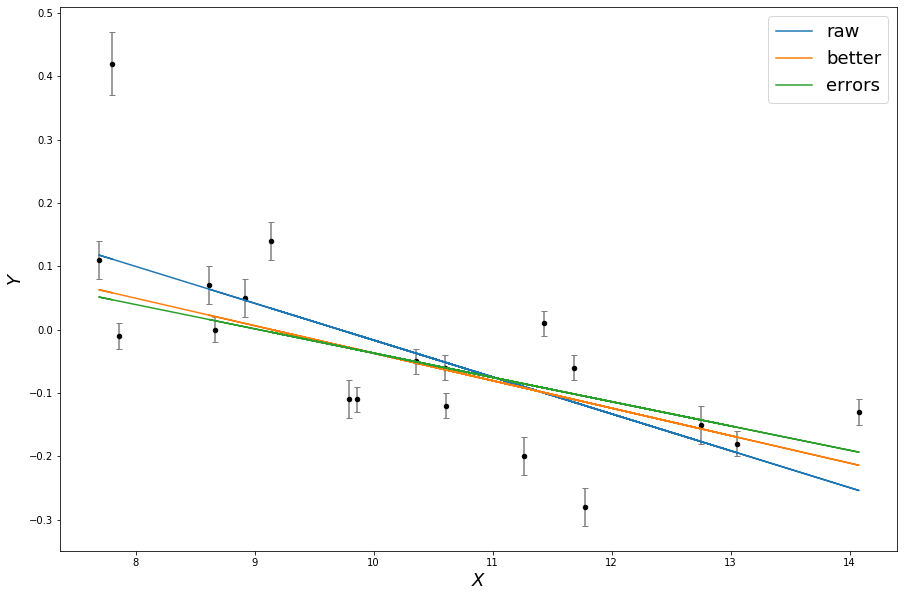

In [35]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0584, mean intercept: 0.5681


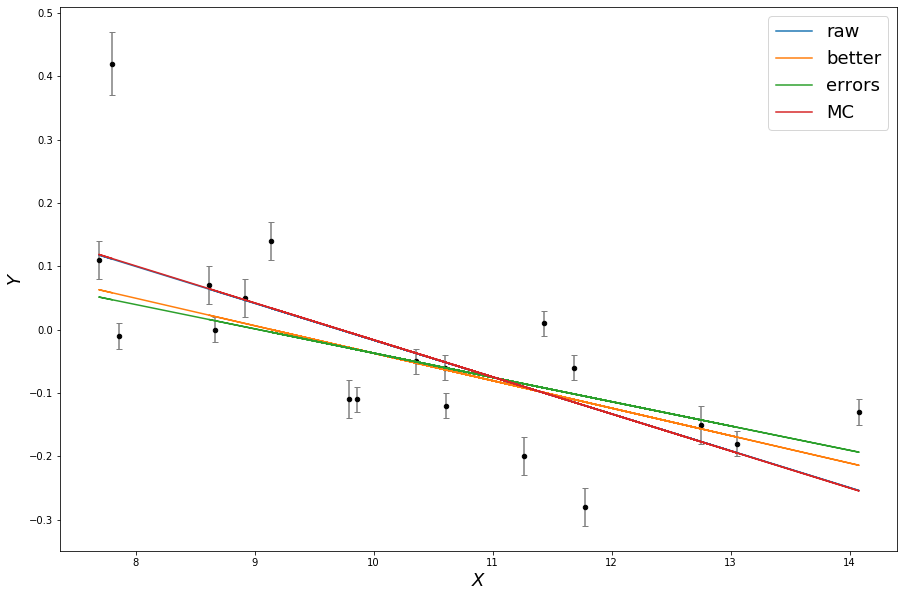

In [36]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [37]:
# oh right, that outlier.

mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  18
slope: -0.0435 $\pm$ 0.0031, mean intercept: 0.3951


slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3946
slope: -0.0436 $\pm$ 0.0034, mean intercept: 0.3953
slope: -0.0433 $\pm$ 0.0033, mean intercept: 0.3929
slope: -0.0432 $\pm$ 0.0034, mean intercept: 0.3915
slope: -0.0439 $\pm$ 0.0034, mean intercept: 0.3979
slope: -0.0437 $\pm$ 0.0033, mean intercept: 0.3968
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3953
slope: -0.0436 $\pm$ 0.0032, mean intercept: 0.3951
slope: -0.0434 $\pm$ 0.0032, mean intercept: 0.3942
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3952
slope: -0.0435 $\pm$ 0.0034, mean intercept: 0.3947
slope: -0.0434 $\pm$ 0.0033, mean intercept: 0.3934
slope: -0.0434 $\pm$ 0.0033, mean intercept: 0.3937
slope: -0.0437 $\pm$ 0.0034, mean intercept: 0.3970
slope: -0.0436 $\pm$ 0.0032, mean intercept: 0.3959
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3951
slope: -0.0434 $\pm$ 0.0034, mean intercept: 0.3937
slope: -0.0434 $\pm$ 0.0031, mean intercept: 0.

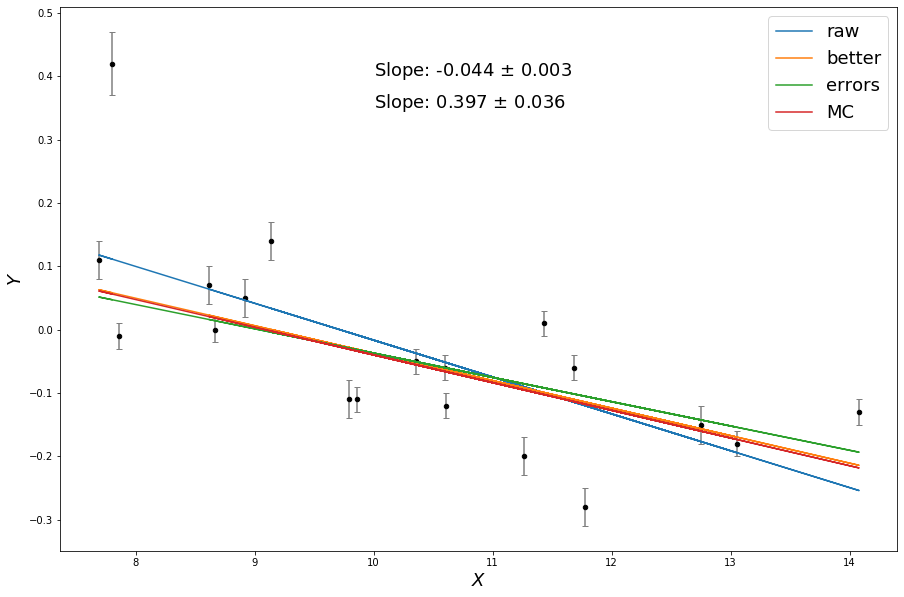

In [38]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

0.39693519717070214


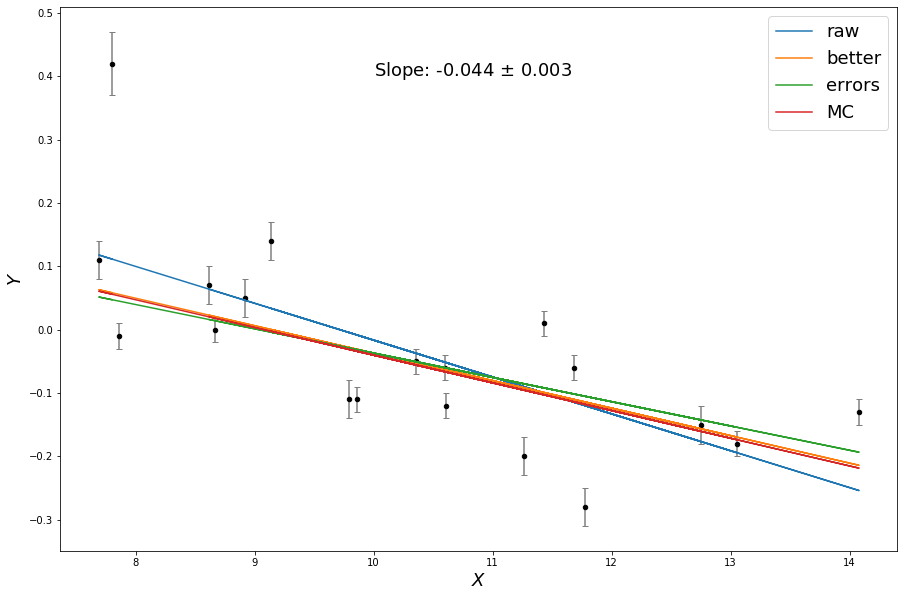

In [39]:
# here's an example of the use of lampda functions: simplifying or modifying another function
params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, ydat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
# ax.text(10, 0.35, "Slope: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

Exercises
=========

Part a)
--------

For X_Err = 0:
Slope: -0.044 $\pm$ 0.003
Intercept: 0.397 $\pm$ 0.036 

For X_Err = 0.5:
Slope: -0.055 $\pm$ 0.006
Intercept: 0.533 $\pm$ 0.065

For X_Err = abs(X - 8)/10:
Slope: -0.057 $\pm$ 0.005
Intercept: 0.554 $\pm$ 0.052


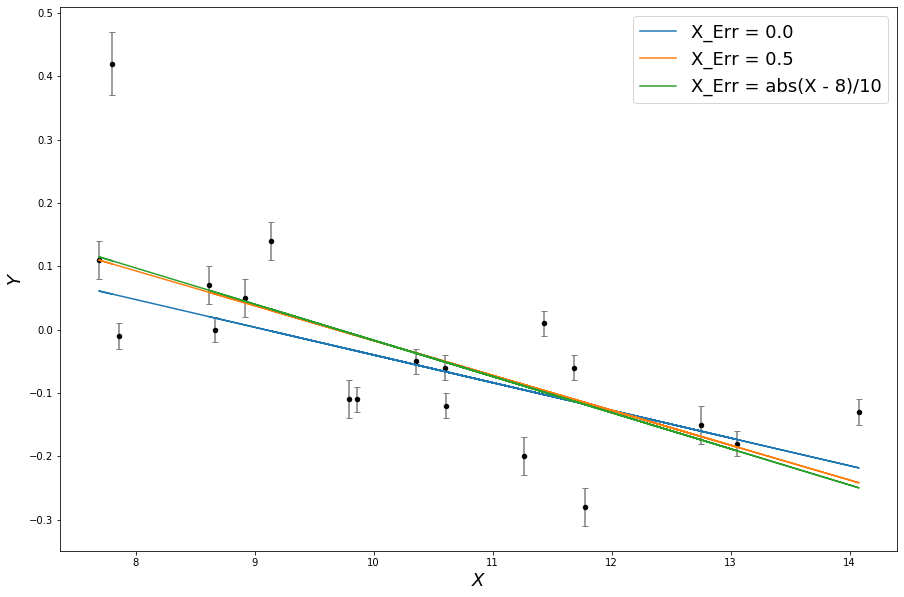

In [41]:
# exercise: we can't know the x data perfectly
# suppose the data have uniform x errors of 0.5
# use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors
# repeat this exercise, but supposing the errors INCREASE as we move away from X = 8 (as they do)
# to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit

def mcFit_mod(x, y, y_err, x_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))
        xweights = np.random.randn(len(x))
        y_adj = y + y_err*weights
        x_adj = x + x_err*xweights

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope1, intercept1 = mcFit_mod(data['X'], data['Y'], data['Y_ERR'], 0.5)
slope2, intercept2 = mcFit_mod(data['X'], data['Y'], data['Y_ERR'], (abs(data['X']-8)/10))


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'], yerr=data['Y_ERR'], c='tab:gray', fmt='.', markersize=1, capsize=3 ,zorder=0)

ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='X_Err = 0.0')
ax.plot(data['X'], linear(data['X'], np.mean(slope1), np.mean(intercept1)), label='X_Err = 0.5')
ax.plot(data['X'], linear(data['X'], np.mean(slope2), np.mean(intercept2)), label='X_Err = abs(X - 8)/10')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

print("For X_Err = 0:")
print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)))
print("Intercept: {:5.3f} $\pm$ {:5.3f} \n".format(np.mean(intercept), np.std(intercept)))

print("For X_Err = 0.5:")
print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope1), np.std(slope1)))
print("Intercept: {:5.3f} $\pm$ {:5.3f}\n".format(np.mean(intercept1), np.std(intercept1)))

print("For X_Err = abs(X - 8)/10:")
print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope2), np.std(slope2)))
print("Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept2), np.std(intercept2)))

plt.legend(loc='best', fontsize=18)
plt.show()


In [ ]:
# plot both slopes. how does the fit change? 

Marginal change dude to small values but increasing X_Err with X does produce slightly greater slope which makes sense given the distribution of the data

Part b)
======

Redo of Analysis above for X vs. Z data
----------------------------------------

raw:  0.006717675713445995 -0.0687541345289338
raw:  [ 2.7536905e-05 -2.8399245e-04] [-0.00028399  0.00301949]


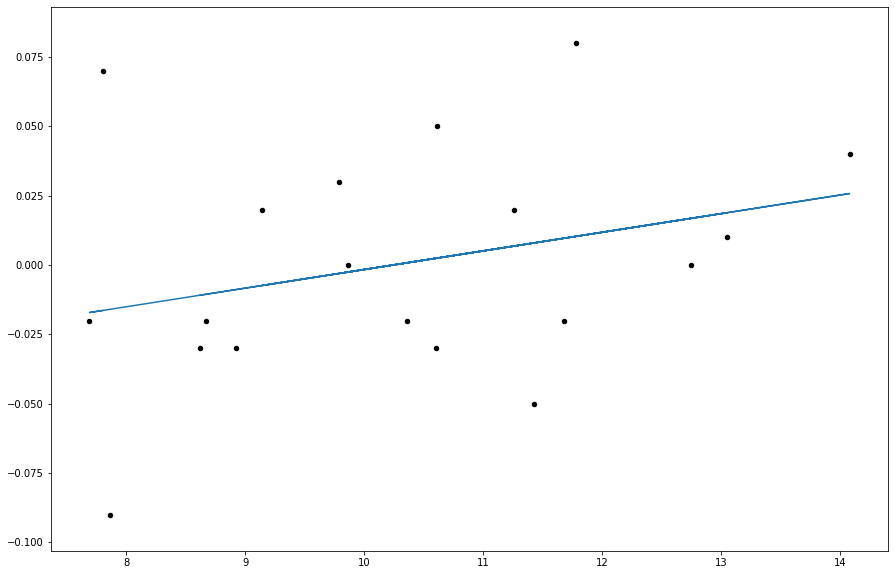

In [43]:
# Repeat the above anaysis for X vs. Z data, including uncertainties!!

popt, pcov = opt.curve_fit(linear, data['X'], data['Z'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))

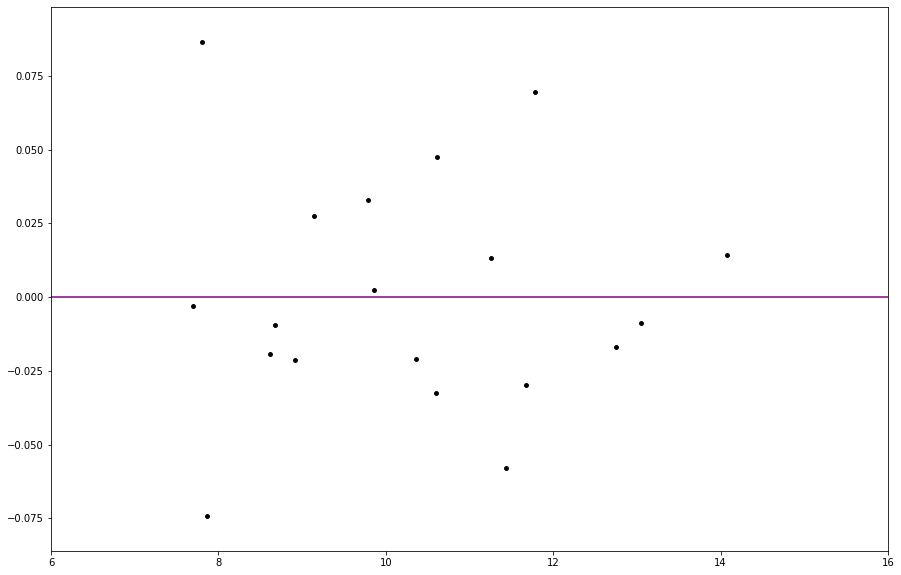

In [44]:
residual = data['Z']-linear(data['X'],*popt)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.2
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  0.006717675713445995 -0.0687541345289338
outliers accounted for:  0.006766707931389952 -0.06938331415905287


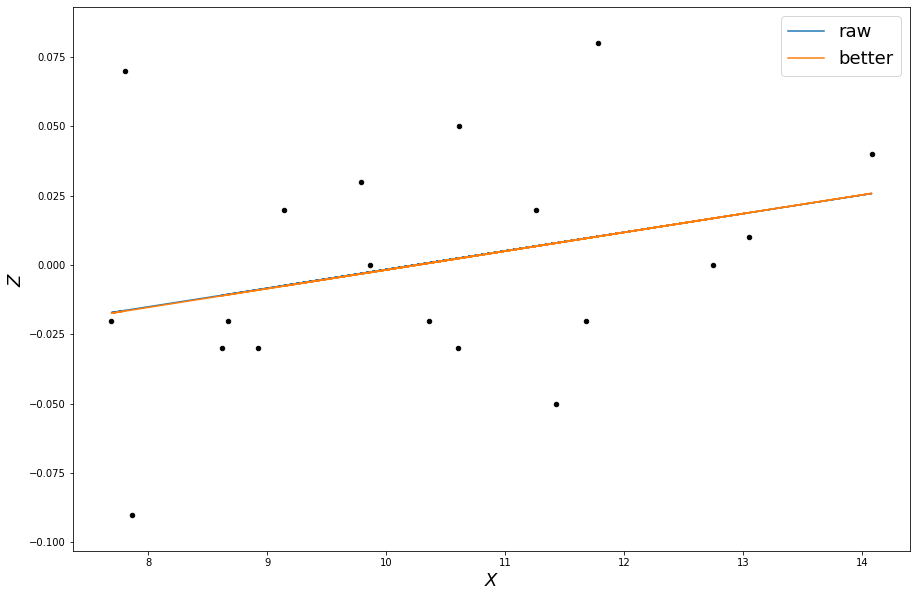

In [45]:
popt, pcov = opt.curve_fit(linear, data['X'], data['Z'])
print("raw: ", *popt)


popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Z'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black',zorder=2)


ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

0.005358711605572734 -0.058178020691403


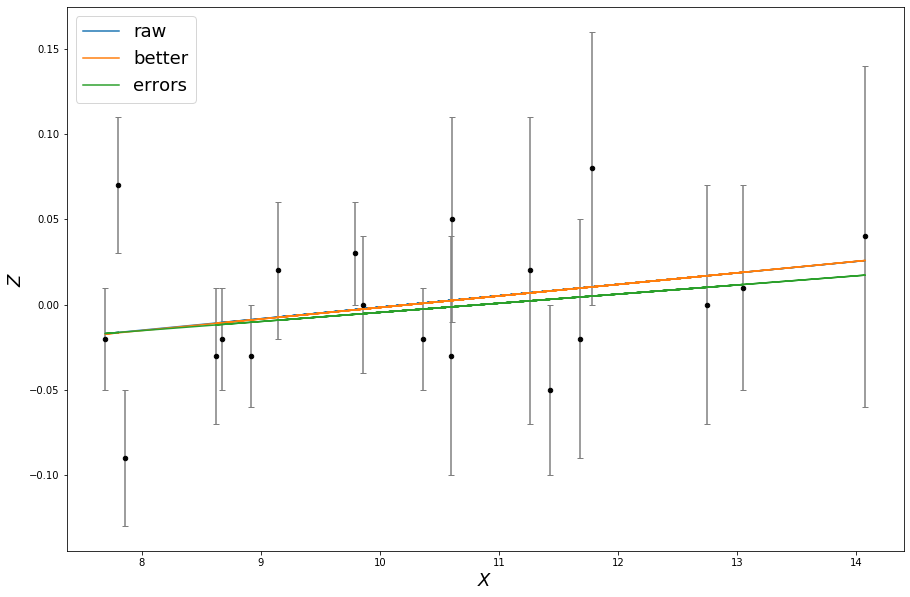

In [46]:
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Z'], sigma=data['Z_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)


ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: 0.0069, mean intercept: -0.0697


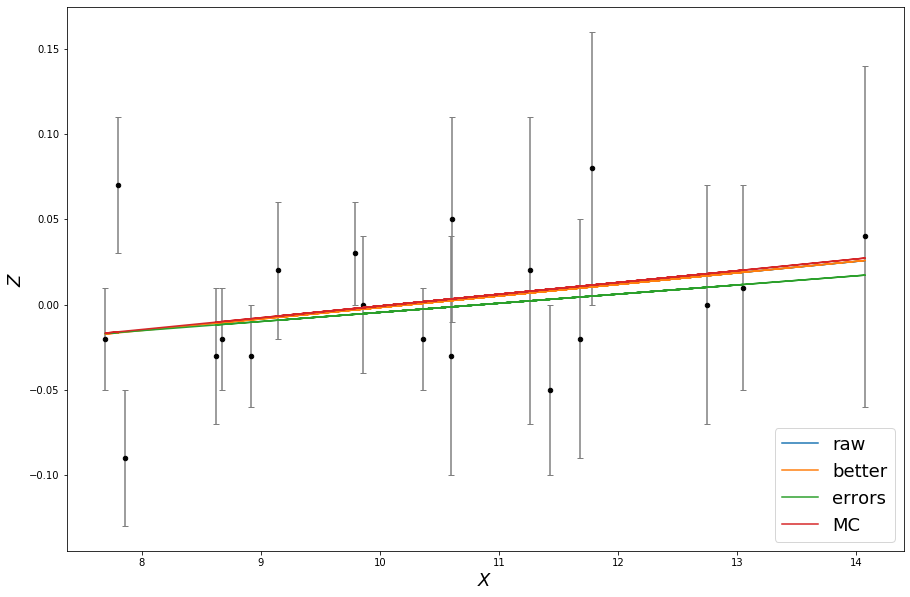

In [47]:
slope, intercept = mcFit(data['X'], data['Z'], data['Z_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [52]:
mask = data['Z'] > -0.075

xdat = data['X'][mask]
zdat = data['Z'][mask]
zdat_err = data['Z_ERR'][mask]

mask = data['Z'] < 0.075

xdat = data['X'][mask]
zdat = data['Z'][mask]
zdat_err = data['Z_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, zdat, zdat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")

for i in range(20):
    slope, intercept = mcFit(xdat, zdat, zdat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

data size:  18
slope: +0.0053 $\pm$ 0.0083, mean intercept: -0.0575


slope: +0.0050 $\pm$ 0.0084, mean intercept: -0.0544
slope: +0.0055 $\pm$ 0.0087, mean intercept: -0.0598
slope: +0.0048 $\pm$ 0.0087, mean intercept: -0.0528
slope: +0.0050 $\pm$ 0.0090, mean intercept: -0.0549
slope: +0.0046 $\pm$ 0.0086, mean intercept: -0.0517
slope: +0.0049 $\pm$ 0.0084, mean intercept: -0.0534
slope: +0.0049 $\pm$ 0.0082, mean intercept: -0.0547
slope: +0.0055 $\pm$ 0.0087, mean intercept: -0.0589
slope: +0.0050 $\pm$ 0.0085, mean intercept: -0.0547
slope: +0.0049 $\pm$ 0.0086, mean intercept: -0.0542
slope: +0.0047 $\pm$ 0.0082, mean intercept: -0.0533
slope: +0.0048 $\pm$ 0.0084, mean intercept: -0.0536
slope: +0.0048 $\pm$ 0.0080, mean intercept: -0.0524
slope: +0.0046 $\pm$ 0.0084, mean intercept: -0.0507
slope: +0.0053 $\pm$ 0.0084, mean intercept: -0.0580
slope: +0.0045 $\pm$ 0.0086, mean intercept: -0.0506
slope: +0.0052 $\pm$ 0.0084, mean intercept: -0.0559
slope: +0.0042 $\pm$ 0.0082, 

Slope: +0.005 $\pm$ 0.009
Intercept: -0.050 $\pm$ 0.081


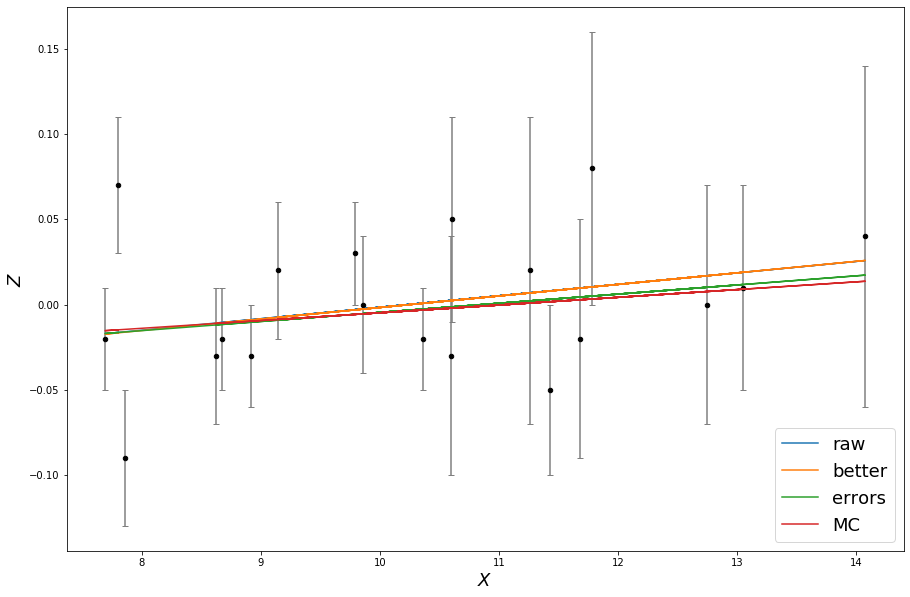

In [53]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, zdat, zdat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)))
print("Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)))

plt.legend(loc='best', fontsize=18)
plt.show()

-0.050316230882402335
Slope: +0.005 $\pm$ 0.009


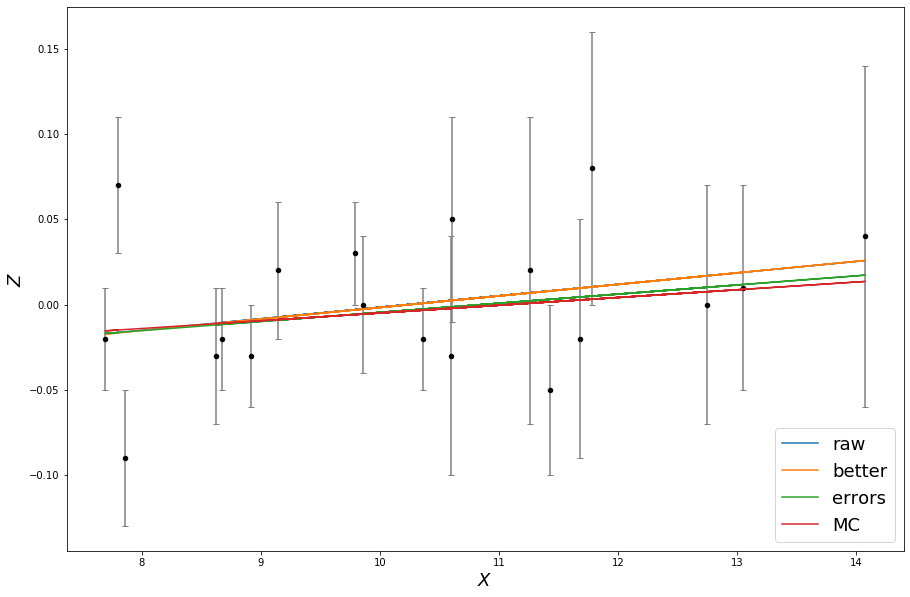

In [54]:
params, other = opt.curve_fit(lambda x, b: linear(x, np.mean(slope), b), xdat, zdat)

fixed_int = params[0]

print(fixed_int)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'],yerr=data['Z_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), fixed_int), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)))


plt.legend(loc='best', fontsize=18)
plt.show()

Addition of X_Err
------------

For X_Err = 0:
Slope: +0.006 $\pm$ 0.008
Intercept: -0.065 $\pm$ 0.076 

For X_Err = 0.5:
Slope: +0.006 $\pm$ 0.008
Intercept: -0.066 $\pm$ 0.080

For X_Err = abs(X - 8)/10:
Slope: +0.006 $\pm$ 0.008
Intercept: -0.066 $\pm$ 0.077


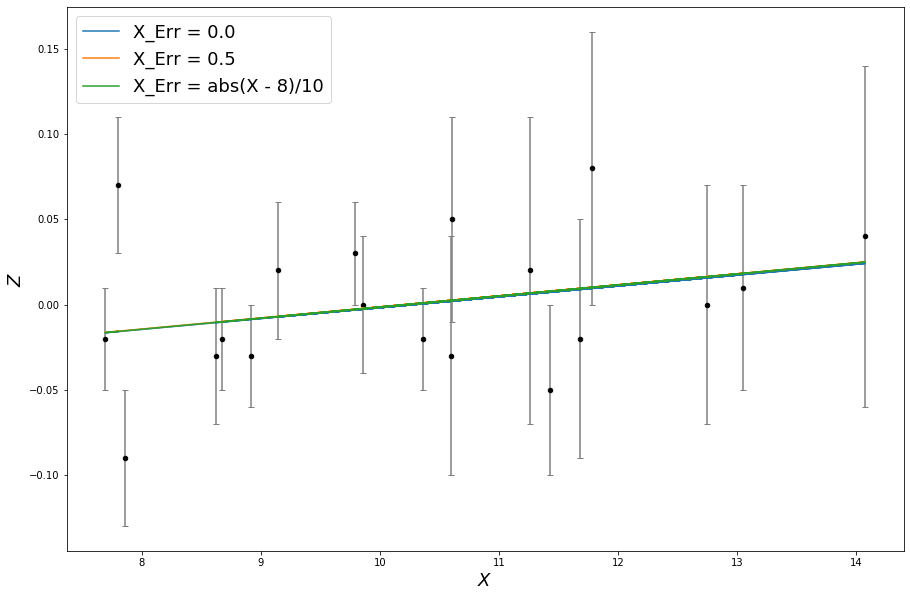

In [55]:
def mcFit_modZ(x, z, z_err, x_err):
    slopes = list()
    z_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(z))
        xweights = np.random.randn(len(x))
        z_adj = z + z_err*weights
        x_adj = x + x_err*xweights

        params, other = opt.curve_fit(linear, x_adj, z_adj)
        slopes.append(params[0])
        z_ints.append(params[1])
    
    return slopes, z_ints

slopez, interceptz = mcFit(data['X'], data['Z'], data['Z_ERR'])
slope1, intercept1 = mcFit_modZ(data['X'], data['Z'], data['Z_ERR'], 0.5)
slope2, intercept2 = mcFit_modZ(data['X'], data['Z'], data['Z_ERR'], (abs(data['X']-8)/10))


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Z'], yerr=data['Z_ERR'], c='tab:gray', fmt='.', markersize=1, capsize=3 ,zorder=0)

ax.plot(data['X'], linear(data['X'], np.mean(slopez), np.mean(interceptz)), label='X_Err = 0.0')
ax.plot(data['X'], linear(data['X'], np.mean(slope1), np.mean(intercept1)), label='X_Err = 0.5')
ax.plot(data['X'], linear(data['X'], np.mean(slope2), np.mean(intercept2)), label='X_Err = abs(X - 8)/10')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

print("For X_Err = 0:")
print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slopez), np.std(slopez)))
print("Intercept: {:5.3f} $\pm$ {:5.3f} \n".format(np.mean(interceptz), np.std(interceptz)))

print("For X_Err = 0.5:")
print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope1), np.std(slope1)))
print("Intercept: {:5.3f} $\pm$ {:5.3f}\n".format(np.mean(intercept1), np.std(intercept1)))

print("For X_Err = abs(X - 8)/10:")
print("Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope2), np.std(slope2)))
print("Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept2), np.std(intercept2)))

plt.legend(loc='best', fontsize=18)
plt.show()

Not much change in fit due to large Z errors dominating